# Research Question 3 - Hubs and Authorities

Do authorities within the Reddit-Climate network excite the debate particularly?
- Hypothesis: Yes. We hypothesize that authority redditors defined by a high in-degree will excite the debate due to their wider outreach which potentially can elevate the discussion on the forum. Similarly, we hypothesize that authorities defined from Reddit awards received will excite the debate since awards might indicate a strong opinion to the topic, which can provide basis for the discussion to excite.

Before answering this Research Question (RQ) a selection of modules and useful functions will be imported.

## 1) Import packages

In [1]:
import os
from pathlib import Path
import json
import bz2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from tqdm.notebook import tqdm
tqdm.pandas()

from collections import Counter

import networkx as nx
from networkx.readwrite import json_graph

import netwulf as nw

In [2]:
# graph loading function
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [94]:
# define plotting function
def LogAndLinearHist(data, xlabel='', figsize=((8,3)), dpi=100):
    min_val, max_val = (min(data), max(data))
    
    # compute bins
    log_bins = np.logspace(min_val if min_val == 0 else np.log10(min_val), np.log10(max_val), 21)
    lin_bins = np.linspace(min_val, max_val, 101)

    # create histogram values
    hist_log, edges_log = np.histogram(data.values, log_bins, density=True)
    hist_lin, edges_lin = np.histogram(data.values, lin_bins)

    # determine x-values
    log_x = (edges_log[1:] + edges_log[:-1]) / 2.
    lin_x = (edges_lin[1:] + edges_lin[:-1]) / 2.

    xx, yy = zip(*[(i,j) for (i,j) in zip(log_x, hist_log) if j > 0])
    
    # plot figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)

    # linear scale plot
    ax[0].plot(lin_x, hist_lin, marker='.', alpha=0.5)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('count')
    ax[0].set_title('linear scale')
    #ax[0].legend()

    # log-log scale plot
    ax[1].plot(xx, yy, marker='.', alpha=0.5)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('probability density')
    ax[1].set_title('log-log scale')
    #ax[1].legend()

    # show figure
    plt.tight_layout()
    plt.show()

In [3]:
DATA_DIR = Path(os.getcwd()) / 'data'

## 2) Load ClimateGraph

As explained in the explainer notebook, this analysis is restricted to the year of 2020.

In [4]:
year = 2020

ClimateGraph = read_json_file(DATA_DIR / f'{year}/ClimateGraph_{year}.json')

## 3) Determining hubs and authorities

As explained in the explainer notebook, this RQ will regard authority nodes from to different perspectives; 1) in-degree and 2) Redditor awards. Furthermore, the definition of hub nodes associated to an authority node will be investigated in two different ways; 1) by looking at the direct incoming neighbors to the authority node (1-layer hub) and 2) by extending this to also incorporate incoming neighbors of the directly linked neighbors to an authority node (2-layer hub).

#### Hubs (definition)

For this RQ 1-layer hubs are investigated. The hub nodes of an authority nodes are in practice found by using applying the `nx`-method `Graph.in_edges(node)` on all authority nodes. Next, the hub opinion score is computed using the mean - this choice is based on the fact (from the preliminary analysis) that the general opinion score is somewhat symmetrically distributed around 0 in the range between -1 and 1 with many authors having an opinion score close to 0.

### 3.1) In-degree authorities

As was seen in the preliminary analysis of the ClimateGraph, 98 Reddit authors had an in-degree larger than 50. This, (somehow) arbitrary threshold value is used to extract authority nodes. Note that being an authority node does not restrict a node from occurring in the hub of other authority nodes.

The computations and the division of hubs and authoritiy nodes are implemented below.

In [5]:
opinion_dict = nx.get_node_attributes(ClimateGraph, 'opinion_score')

In [103]:
# sort the graph wrt. in-degree
authors, in_degree = list(zip(*ClimateGraph.in_degree))
authors, in_degree = zip(*sorted(zip(authors, in_degree), key=lambda x: x[1], reverse=True))

authors, in_degree =pd.Series(authors), pd.Series(in_degree)

# restrict the graph to the authorities given by the in-degree definition
top_authorities = authors[in_degree > 50]
in_degree = in_degree[in_degree > 50]

# get opinion scores for all authority authors
authority_indegree, hub_indegree = [], []
for node in top_authorities:

    # 1st layer neighbors of the authority nodes
    incoming_neighbors = list(list(zip(*ClimateGraph.in_edges(node)))[0])
    
    # compute the hub opinion
    hub_opinion = pd.Series([opinion_dict[neighbor_node] for neighbor_node in incoming_neighbors])
    hub_indegree.append(hub_opinion.mean())
    
    # get the authority opinion
    authority_indegree.append(opinion_dict[node])

# collect in a dataframe
auth_hub_scores = pd.DataFrame([hub_indegree, authority_indegree, in_degree], columns=top_authorities, 
                    index=['hub_opinion', 'authority_opinion', 'in_degree']).T

In [104]:
auth_hub_scores.head(10)

,hub_opinion,authority_opinion,in_degree
wokehedonism,-0.043469,-0.066667,732.0
Wagamaga,-0.066568,0.062500,646.0
Return_The_Slab_Boi,-0.176541,-0.065789,634.0
RepublicanBoy365,-0.090454,-0.055556,502.0
duckotterotterduck,-0.045199,0.642857,446.0
The_American_Skald,-0.043549,0.011111,408.0
II-I-Hulk-I-II,-0.061530,-0.500000,373.0
intravenousTHC,-0.045051,0.500000,363.0
progress18,-0.047357,-0.027778,272.0
Yosoff,-0.074649,0.000000,235.0


These two distributions - of authority opinion and their associated hub-opinion - are visualized in the figure below.

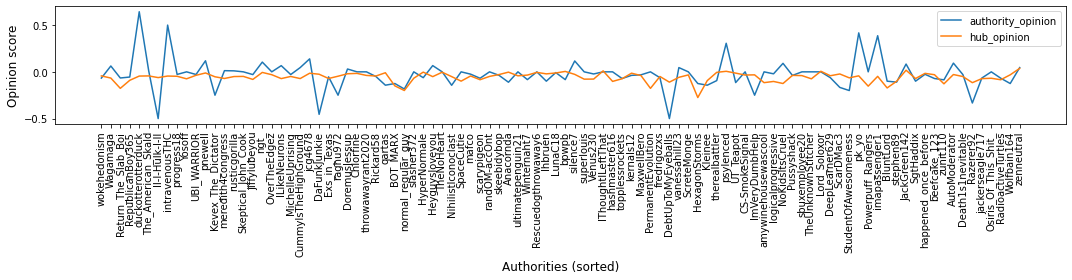

In [105]:
auth_hub_scores.plot(y=['authority_opinion', 'hub_opinion'], figsize=((15,4)))

plt.xticks(np.arange(auth_hub_scores.__len__()), 
           auth_hub_scores.index,
           rotation=90)
plt.xlabel('Authorities (sorted)', fontsize=12)
plt.ylabel('Opinion score', fontsize=12)

plt.tight_layout()
plt.show()

As the research question aims at adressing whether the authority opinion is different than the hub opinion, it is necessary to apply a statistical test examining the difference of the mean between the distributions. In order to validly determine whether this statistical test should be with a parametric or non-parametric test, it is necessary to analyse the variance of the distributions.

In [106]:
auth_hub_scores[['authority_opinion', 'hub_opinion']].var()

authority_opinion    0.025611
hub_opinion          0.002478
dtype: float64

As is seen above, the variances are not equal between the two independent groups and the standard unpaired t-test can thus not be applied. The Welch's t-test is the non-parametric version of the t-test where the assumption of equal variance is disregarded.

In [107]:
ttest_ind(auth_hub_scores['authority_opinion'], auth_hub_scores['hub_opinion'], equal_var=False)

Ttest_indResult(statistic=1.7341534588896603, pvalue=0.08555666117125241)

The fact that the p-value is equal to 0.08 suggests that the null-hypothesis can not be rejected on a 95% significance level. This means, that we can not reject that there is no difference between authority and hub opinion. The mean values of the two distributions are computed below. As can be seen, they are close to 0, meaning "Neutral" opinion in the Climate Change debate. 

In [109]:
auth_hub_scores[['authority_opinion', 'hub_opinion']].mean()

authority_opinion   -0.027537
hub_opinion         -0.056896
dtype: float64

It is worth mentioning that using a 90% confidence level would flip the conclusion, providing for evidence that hub-nodes would have a more negative opinion than authority nodes which can be seen from the mean values above as well as from the fact that hub opinion is rarely overshooting authority opinion scores in the above figure. When this is said, both mean opinion score values are still too close to 0 to fit in line with the initially propsed hypothesis.

### 3.2) Award-based authorities

As was seen in the preliminary analysis of the ClimateGraph, 135 Reddit authors in the graph were awarded with one or more Reddit awards. In this section, awardings serve as the threshold-decision, meaning that authority nodes are the ones who are given at least one award. Following this approach, there is a chance of authority nodes having no incoming links / neighbors. This will be handled by removing such authority-hub pairs in the following investigation.

The computations and the division of hubs and authoritiy nodes are implemented below.

In [51]:
awards_dict = nx.get_node_attributes(ClimateGraph, 'total_awards_received')

In [120]:
authors, awards = zip(*sorted(nx.get_node_attributes(ClimateGraph, 'total_awards_received').items(), key=lambda x: x[1], reverse=True))
authors, awards =pd.Series(authors), pd.Series(awards)

top_authorities = authors[awards > 0]
awards = awards[awards > 0]

authority_awards, hub_awards, hub_size = [], [], []
for node in top_authorities:
    
    # 1st layer neighbors of the authority nodes
    incoming_neighbors = list(zip(*ClimateGraph.in_edges(node)))
    
    # ensure that authorities without incoming links are disregarded (with nan)
    if incoming_neighbors != []:
        incoming_neighbors = incoming_neighbors[0]
        
        # compute the hub opinion
        hub_opinion = pd.Series([opinion_dict[neighbor_node] for neighbor_node in incoming_neighbors])
        hub_awards.append(hub_opinion.mean())
        hub_size.append(hub_opinion.__len__())

    else:
        hub_awards.append(np.nan)
        hub_size.append(np.nan)
    
    # get the authority opinion
    authority_awards.append(opinion_dict[node])

# collect in a dataframe
auth_hub_scores = pd.DataFrame([hub_awards, authority_awards, awards, hub_size], columns=top_authorities,
            index=['hub_opinion', 'authority_opinion', 'awards', 'hub_size']).T

In [121]:
auth_hub_scores.head(10)

,hub_opinion,authority_opinion,awards,hub_size
Wagamaga,-0.066568,0.062500,15.0,646.0
IntrepidOrchid,0.027708,0.140394,7.0,42.0
thunder-bug-,-0.062564,-0.076923,6.0,30.0
DaFunkJunkie,-0.025552,-0.454545,4.0,147.0
tyragos,-0.101648,-0.166667,4.0,5.0
Comrade-Thanos,-0.079855,0.000000,4.0,11.0
rusticgorilla,-0.050465,0.010684,3.0,196.0
ILikeNeurons,-0.072317,0.066122,3.0,168.0
TrayusV,-0.030971,-0.076923,3.0,42.0
Majestic-Pizza-7842,-0.076389,0.000000,3.0,6.0


As explained, some authorities had no neighboring nodes, thus, they can not be regarded as an authority-hub pair. This amounts to 10 authority-nodes, that are removed from the data.

In [122]:
print(f"Number of award-based authorities without ingoing links: {sum(auth_hub_scores.isnull().T.any())}")

Number of award-based authorities without ingoing links: 10


In [123]:
auth_hub_scores = auth_hub_scores[-(auth_hub_scores.isnull().T.any())]

Similarly to the in-degree-based distributions, the award-based hub-authority opinion score distributions are visualized before conducting a statistical test.

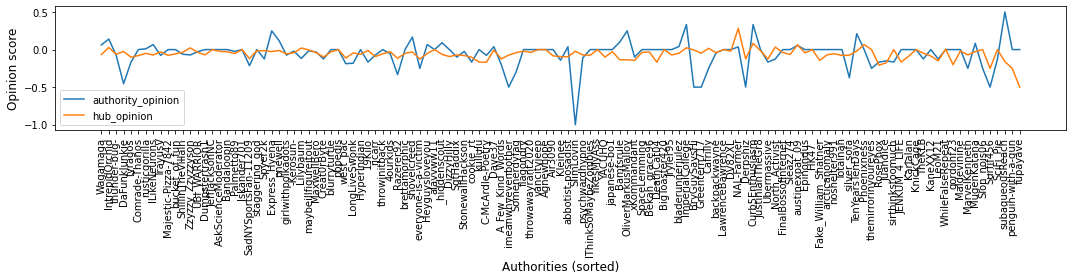

In [124]:
auth_hub_scores.plot(y=['authority_opinion', 'hub_opinion'], figsize=((15,4)))

plt.xticks(np.arange(auth_hub_scores.__len__()), 
           auth_hub_scores.index,
           rotation=90)
plt.xlabel('Authorities (sorted)', fontsize=12)
plt.ylabel('Opinion score', fontsize=12)

plt.tight_layout()
plt.show()

In [125]:
auth_hub_scores[['authority_opinion', 'hub_opinion']].var()

authority_opinion    0.032201
hub_opinion          0.006190
dtype: float64

Once again, the variances are not equal between the two independent groups and the Welch's t-test will be applied.

In [126]:
ttest_ind(auth_hub_scores['authority_opinion'], auth_hub_scores['hub_opinion'], equal_var=False)

Ttest_indResult(statistic=0.00456411800129798, pvalue=0.9963637255487287)

This test certainly reveals that rejecting the null hypothesis of no difference in mean between the hub and authority opinions is off-topic as the p-value is 0.99. Once again, we see average opinion values close to 0, suggesting that the authorities based on awards are also "Neutral" in their opinion to climate change.

In [127]:
auth_hub_scores[['authority_opinion', 'hub_opinion']].mean()

authority_opinion   -0.05783
hub_opinion         -0.05791
dtype: float64

## 4) Conclusion

There is no significant statistical proof that authority do excite the "man-made or not" debate about Climate Change particularly, neither when it comes to authority nodes based on an in-degree threshold or authority nodes based on Reddit awards received. It was seen that the mean opinion values in both cases were close to 0 - meaning neutral about climate change - for which reason the initially stated hypothesis about authority nodes exciting the debate particularly due to a wider outreach on the social media platform does not hold. 

Since both award-based and in-degree based authority-hub pairs are close to zero, there is not much to conclude about the hypothesized reason about excitation of the discussion.